# ENCODE bigWig analysis questions

Do your best to answer all parts of each question. You are encouraged to work in pairs.

Answers to many questions may benefit from using more than one cell, as well as a combination of markdown and code cells.

Put helper functions into a separate script (e.g. hwutils.py) so they can be commented on easily and focus the notebook on plotting. Also see the workshop on Clean Code from Dan Larremore (https://larremorelab.github.io/slides/) for good coding tips to use in this assignment.

In [39]:
# useful libraries to import

import pandas as pd
import numpy as np

import  sklearn.decomposition

import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter
bp_formatter = EngFormatter('b')

import seaborn as sns; sns.set()

# nice way to format ticks as human-readable: ax.xaxis.set_major_formatter(bp_formatter)

##hwutils is a separate script where we can put helper functions
#from hwutils import *

In [40]:
# load dataFrame of bigWigs from ENCODE (encodeproject.org/), binned to 10kb resolution across chromosome 10.
# note that the first three columns are chrom,start,end and the other columns are labeled by bigWig file accession.
df = pd.read_table('/Volumes/GoogleDrive/My Drive/QBIO577/Data/ENCODE_GRCh38_binned_subset.tsv')

# load metadata from ENCODE for bigwig files. 
# can be queried as follows: bigwig_metadata.query("`File accession`==@ df_column_name ")
bigwig_metadata = pd.read_table('/Volumes/GoogleDrive/My Drive/QBIO577/Data/ENCODE_GRCh38_bigWig_metadata.tsv')

/var/folders/vh/c9rgmxsx7rx9w6jhh5l01ymc0000gn/T/ipykernel_15768/3550046313.py:7: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  bigwig_metadata = pd.read_table('/Volumes/GoogleDrive/My Drive/QBIO577/Data/ENCODE_GRCh38_bigWig_metadata.tsv')


### 1. After loading the data (above), and visualize some of the profiles. Why might many signals dip on chr10 at around 40Mb?

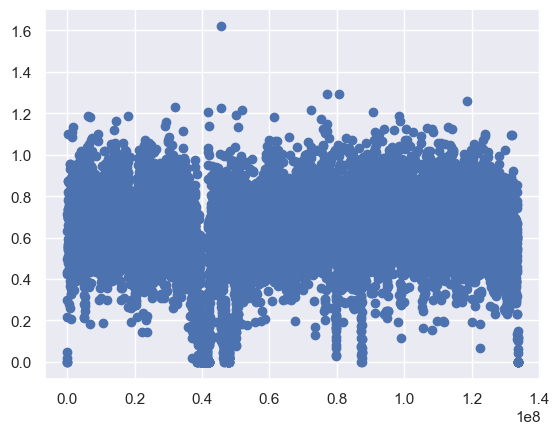

In [3]:
#Visualizing ENCFF230YBR
plt.scatter(df.start,df.ENCFF230YBR)

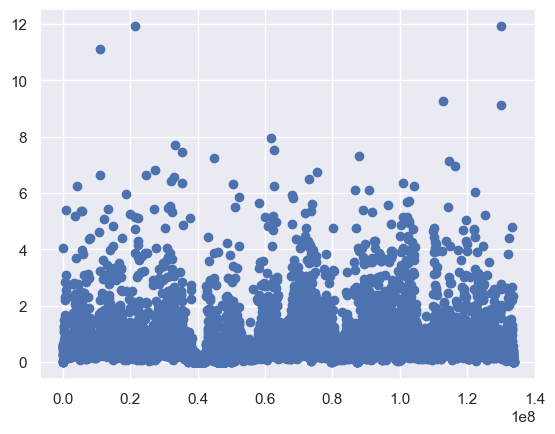

In [4]:
#Visualizing ENCFF520IHF
plt.scatter(df.start,df.ENCFF520IHF)

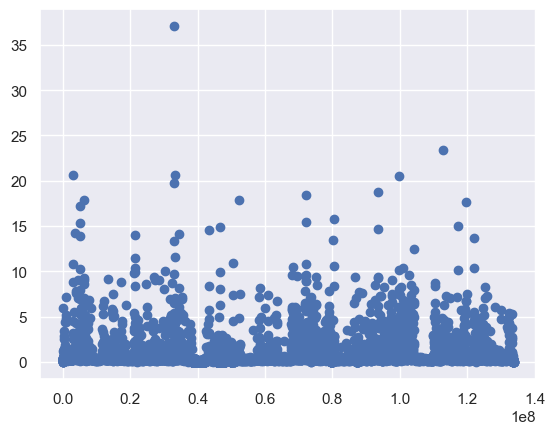

In [5]:
#Visualizing ENCFF640PJT
plt.scatter(df.start,df.ENCFF640PJT)

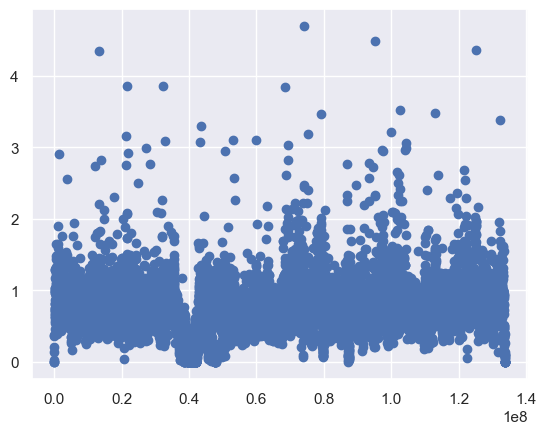

In [6]:
#Visualizing ENCFF919FBG
plt.scatter(df.start,df.ENCFF919FBG)

Some signals dip on chromosome 10 around 40 Mb potentially because of the centromer being located ????

### 2. Use scikit-learn to perform PCA, and make a scatterplot of PC1 vs PC2.

In [41]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
df2 = df.drop(['chrom','start','end'],axis=1) 
pca.fit(df2)

PCA(n_components=2)

In [42]:
df2_pca = pca.transform(df2)

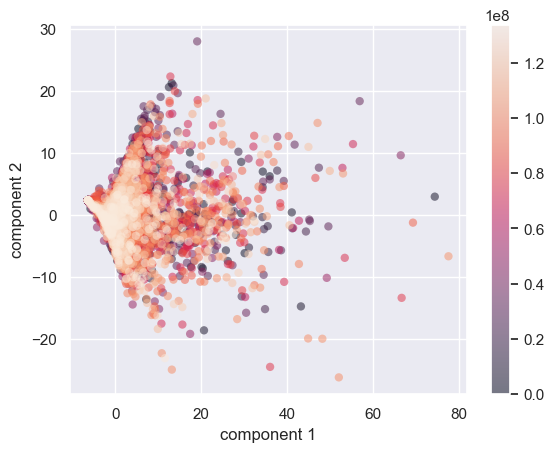

In [45]:
plt.scatter(df2_pca[:, 0], df2_pca[:, 1],
            c=df.start, edgecolor='none', alpha=0.5)
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

### 3. Try to use the experiment metadata to understand and remove outliers. Try labeling or coloring points by various metadata columns. Were any columns in the metadata useful for outlier removal? Note that sklearn.preprocessing.LabelEncoder() can be useful for transforming text strings to categories, and plt.text can be used to overlay labels with points.

In [134]:
def plot_pca( pca , 
             bigwig_metadata=None,
             metadata_label_column=None, 
             alpha=0.5, 
             lw=0, 
             figsize=(8,8)):
    
    """ 
    Skeleton for plotting PCA and annotating the plot. 
    Can be modified/extended to answer various questions.
    """
    
    
    if metadata_label_column is not None:
        if bigwig_metadata is None: 
            raise ValueError("must provide metadata table to label by a metadata column") 
        labels = [bigwig_metadata.query(
                    "`File accession`==@ file_accession ").loc[:,metadata_label_column].values[0]
                  for file_accession in pca.feature_names_in_]
        le = sklearn.preprocessing.LabelEncoder()
        le.fit(labels)
        labels = le.transform(labels)
    else: 
        labels = None
        
    plt.figure(figsize=figsize)
    plt.scatter(pca.components_[0],
                pca.components_[1],
                c = labels,
                alpha=alpha,
                lw=lw
   )

    plt.colorbar()
#    for i, txt in enumerate(labels):
#        plt.annotate(txt, (pca.components_[0][i], pca.components_[1][i]))

In [288]:
import matplotlib.patches as mpatches

def plot_pca( pca , 
             bigwig_metadata=None,
             metadata_label_column=None, 
             alpha=0.5, 
             lw=0, 
             figsize=(8,8)):
    
    """ 
    Skeleton for plotting PCA and annotating the plot. 
    Can be modified/extended to answer various questions.
    """
    
    
    if metadata_label_column is not None:
        if bigwig_metadata is None: 
            raise ValueError("must provide metadata table to label by a metadata column") 
        labels = [bigwig_metadata.query(
                    "`File accession`==@ file_accession ").loc[:,metadata_label_column].values[0]
                  for file_accession in pca.feature_names_in_]
        le = sklearn.preprocessing.LabelEncoder()
        le.fit(labels)
        labels = le.transform(labels)
    else: 
        labels = None
    

    new_labels = le.inverse_transform(labels)
    plt.figure(figsize=figsize)
    c = np.random.rand(5)
    scatter = plt.scatter(pca.components_[0],
                pca.components_[1],
                c = labels,
                cmap = 'Spectral',
                alpha=alpha,
                lw=lw
   )
    classes=np.unique(new_labels).tolist()
    plt.legend(handles=scatter.legend_elements()[0],labels=classes,loc='center left', bbox_to_anchor=(1, 0.5))


#    for i, txt in enumerate(new_labels):
#        plt.annotate(txt, (pca.components_[0][i], pca.components_[1][i]))

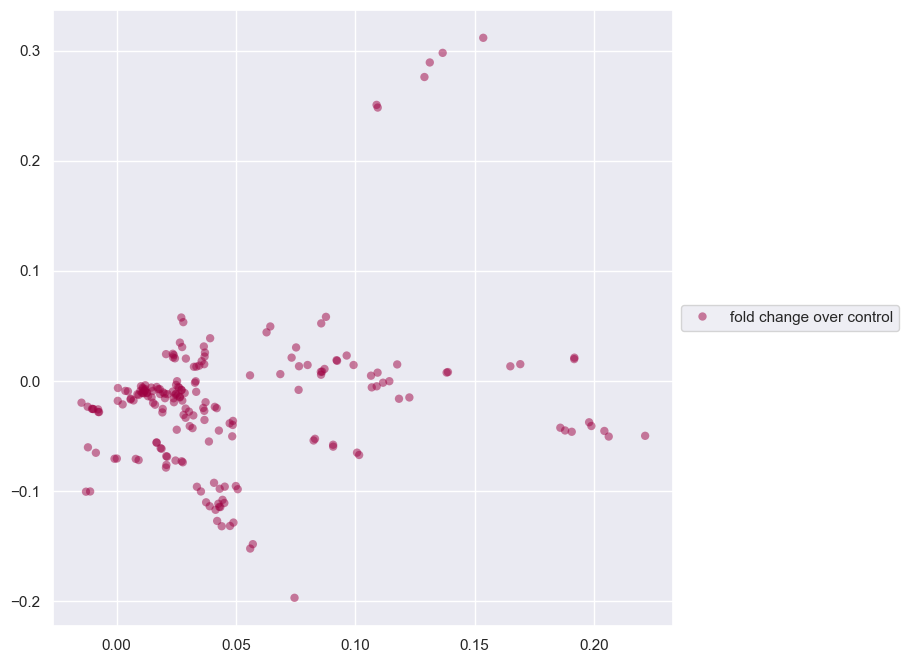

In [290]:
plot_pca(pca,bigwig_metadata=bigwig_metadata,metadata_label_column="Output type")

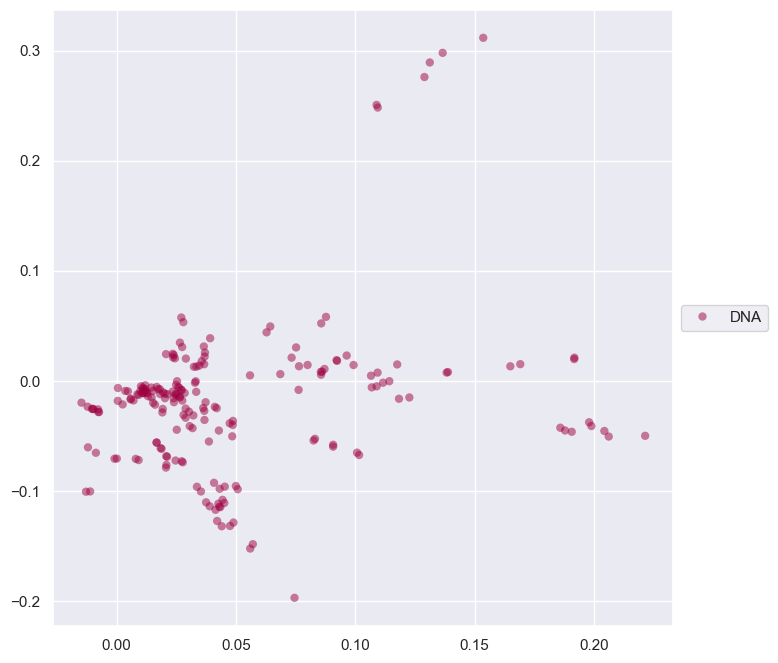

In [291]:
plot_pca(pca,bigwig_metadata=bigwig_metadata,metadata_label_column="Library made from")

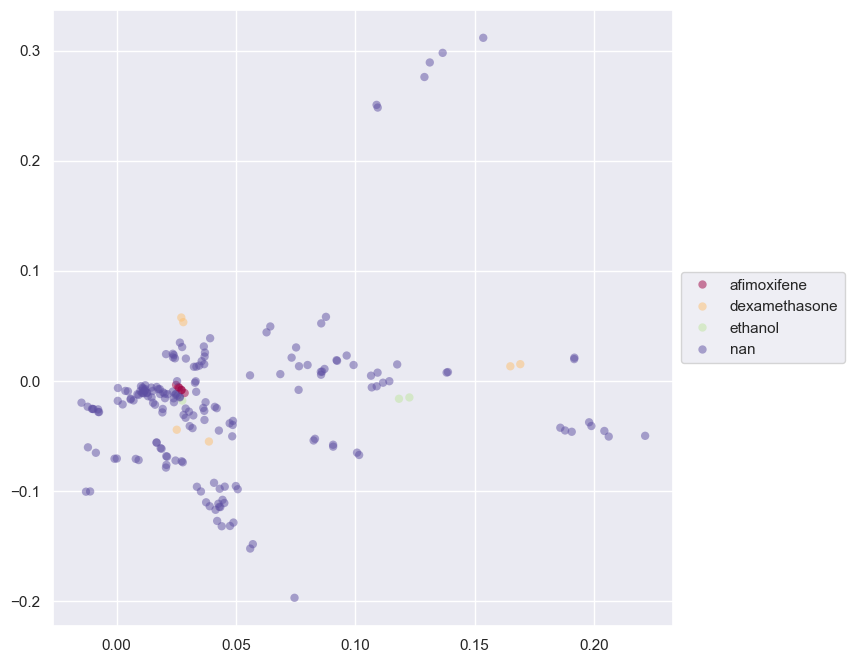

In [292]:
plot_pca(pca,bigwig_metadata=bigwig_metadata,metadata_label_column="Biosample treatments")

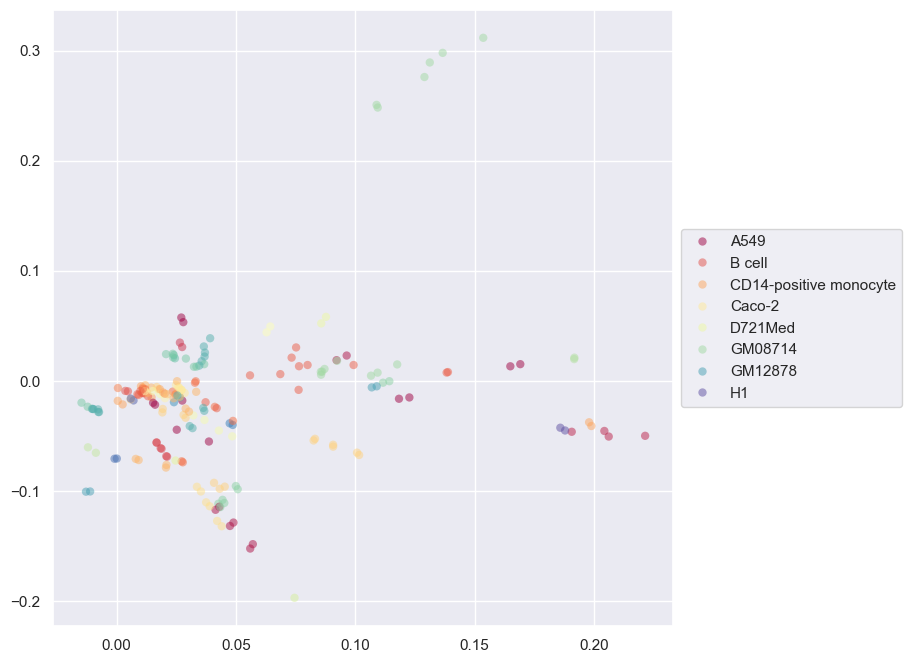

In [293]:
plot_pca(pca,bigwig_metadata=bigwig_metadata,metadata_label_column="Biosample term name")

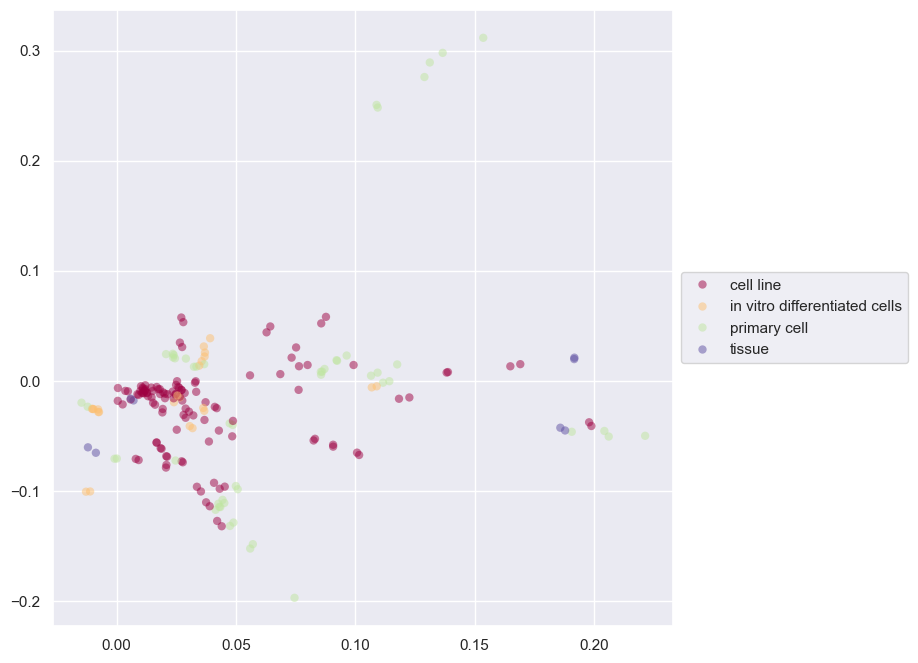

In [294]:
plot_pca(pca,bigwig_metadata=bigwig_metadata,metadata_label_column="Biosample type")

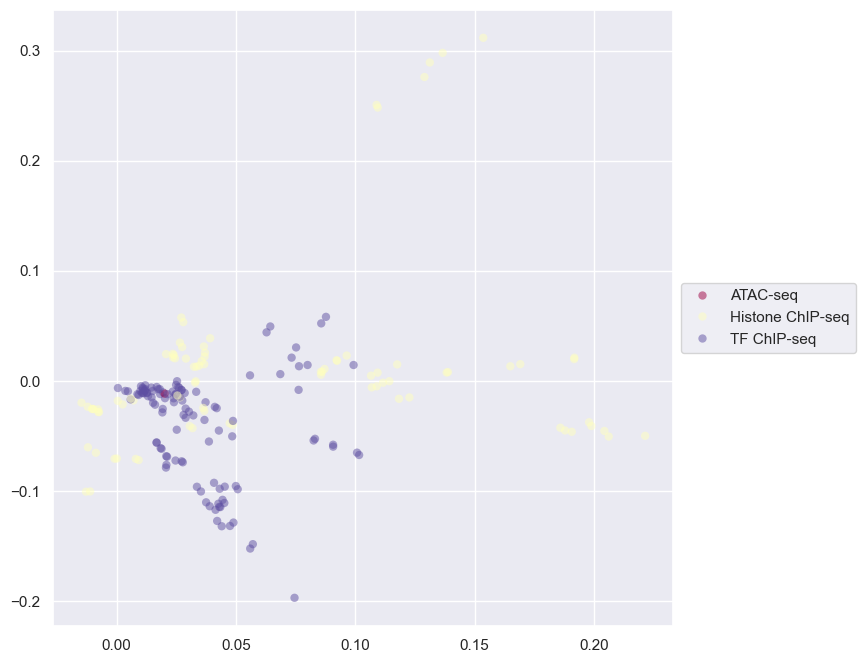

In [295]:
plot_pca(pca,bigwig_metadata=bigwig_metadata,metadata_label_column="Assay")

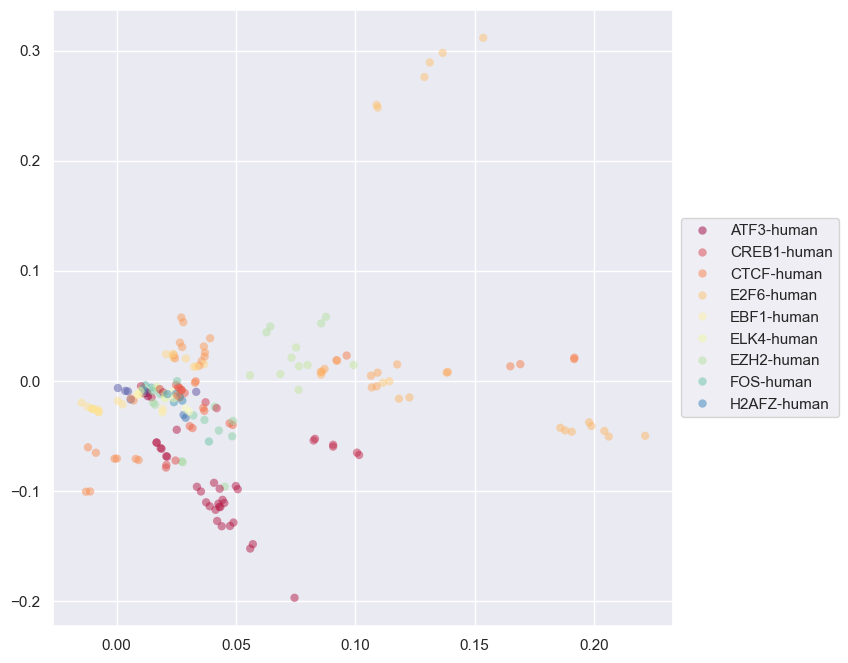

In [296]:
##Seems to be outliers based on 15
plot_pca(pca,bigwig_metadata=bigwig_metadata,metadata_label_column="Experiment target")

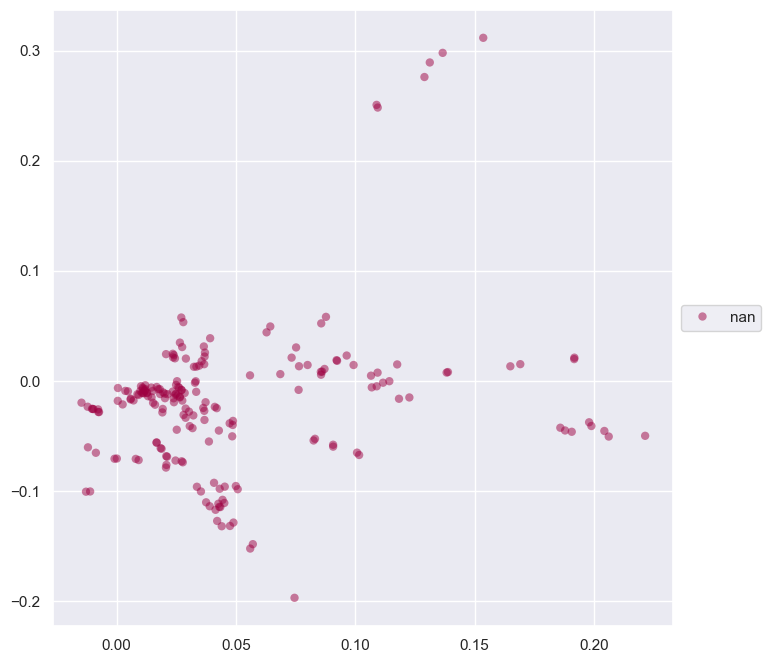

In [297]:
plot_pca(pca,bigwig_metadata=bigwig_metadata,metadata_label_column="Library depleted in")

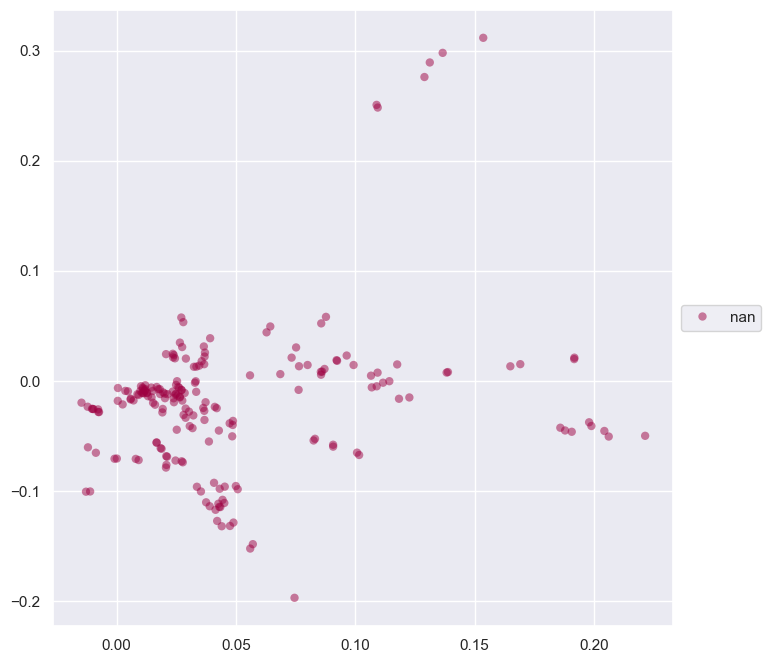

In [298]:
plot_pca(pca,bigwig_metadata=bigwig_metadata,metadata_label_column="Library extraction method")

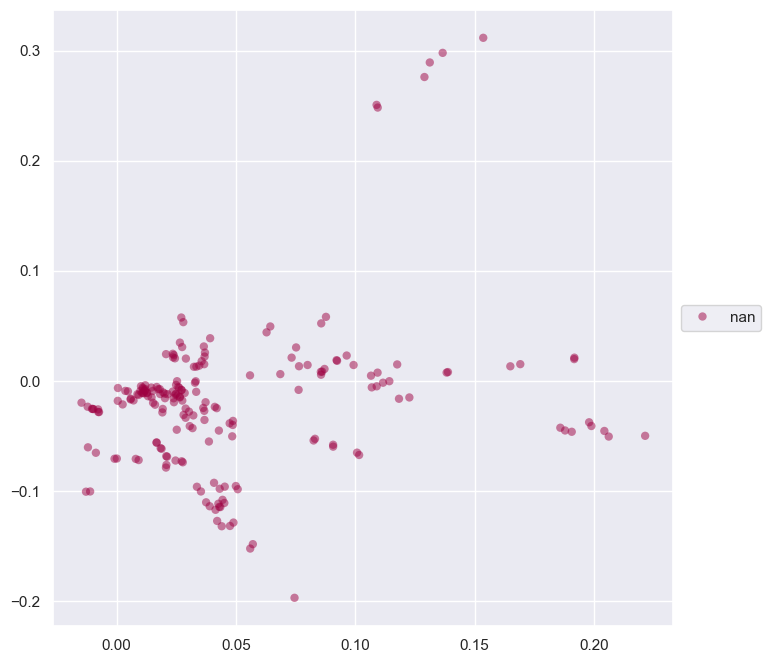

In [299]:
plot_pca(pca,bigwig_metadata=bigwig_metadata,metadata_label_column="Library lysis method")

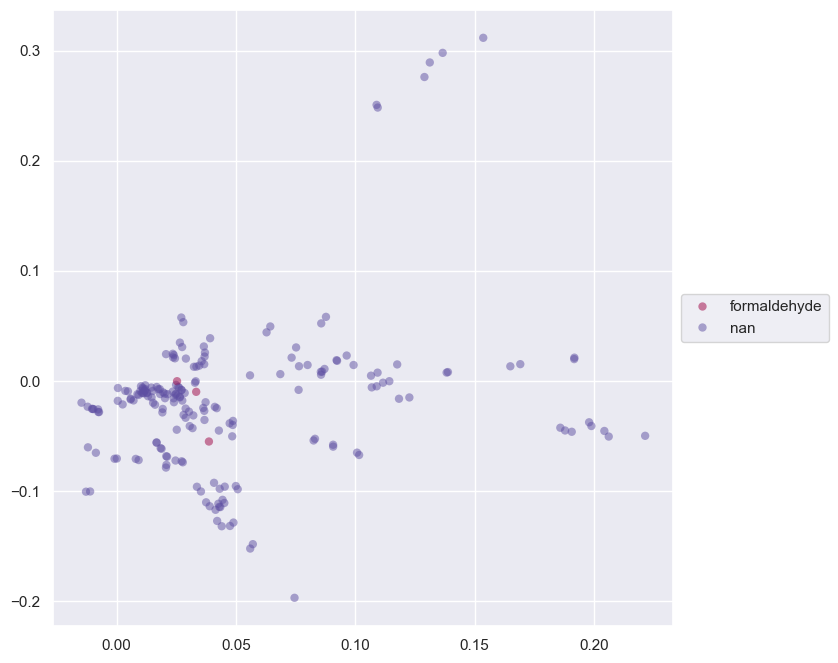

In [300]:
plot_pca(pca,bigwig_metadata=bigwig_metadata,metadata_label_column="Library crosslinking method")

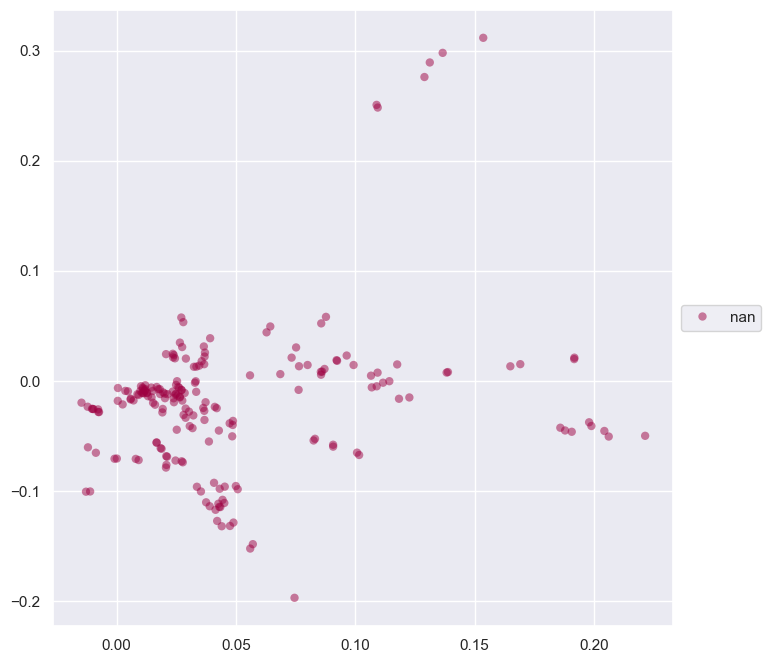

In [301]:
plot_pca(pca,bigwig_metadata=bigwig_metadata,metadata_label_column="Library strand specific")

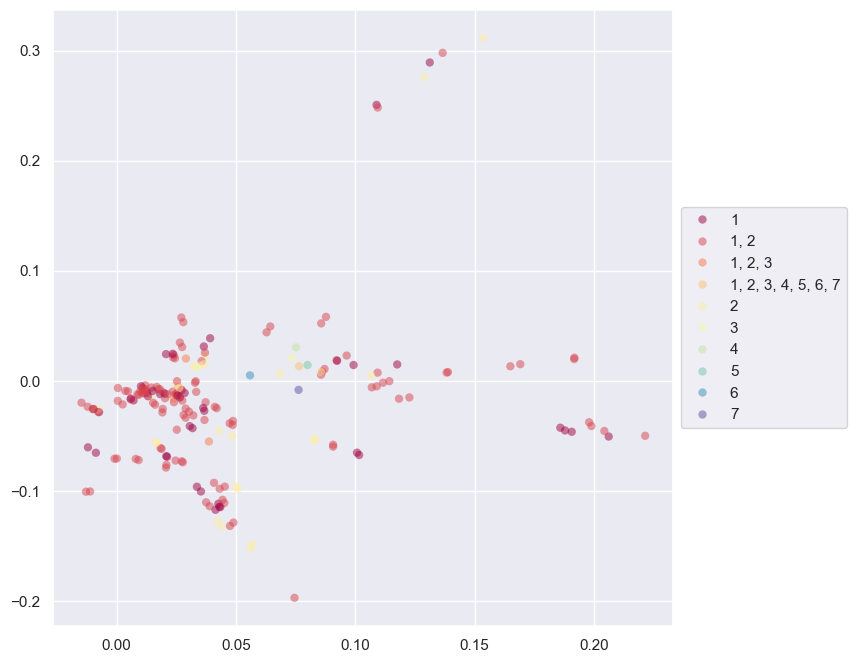

In [302]:
plot_pca(pca,bigwig_metadata=bigwig_metadata,metadata_label_column="Biological replicate(s)")

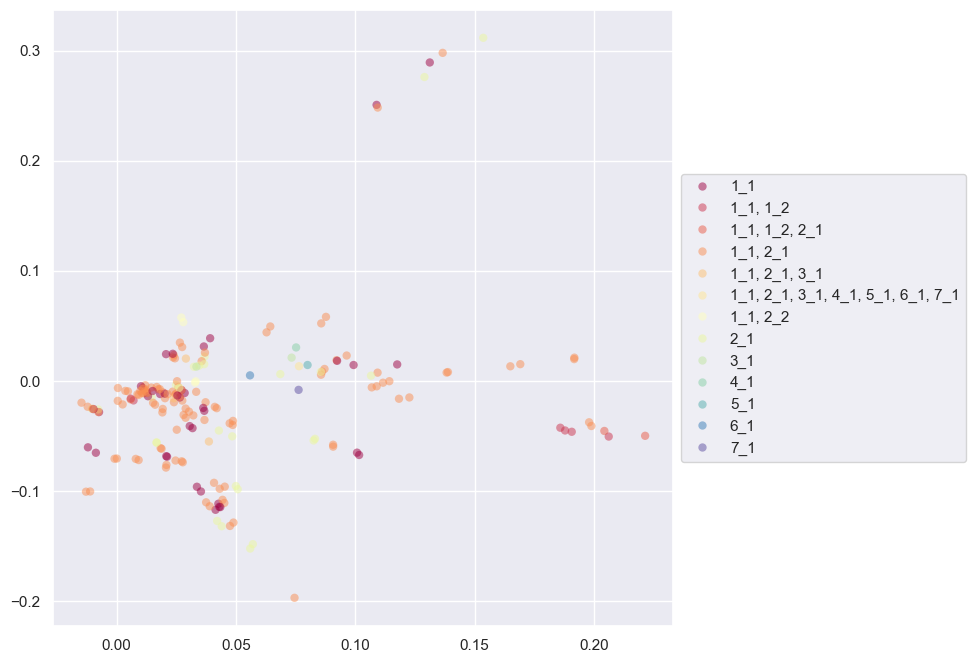

In [303]:
plot_pca(pca,bigwig_metadata=bigwig_metadata,metadata_label_column="Technical replicate(s)")

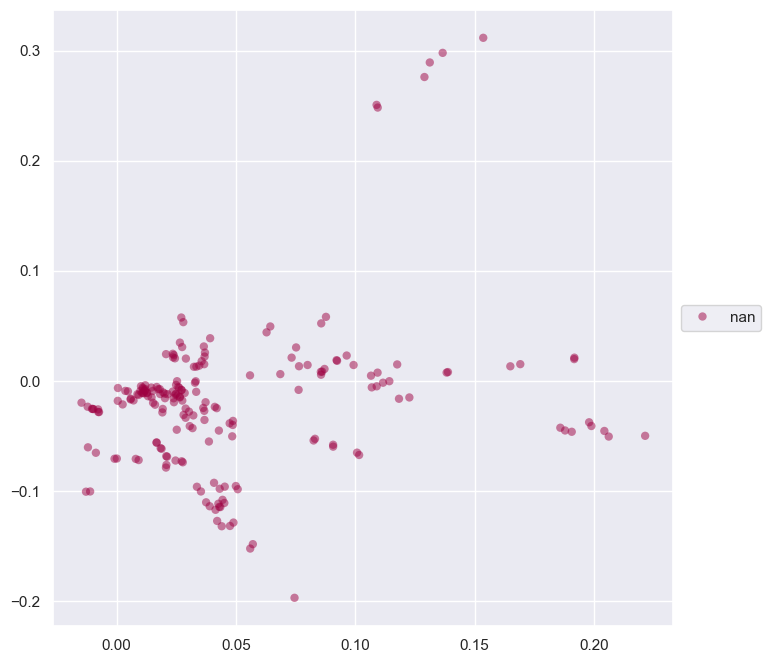

In [304]:
plot_pca(pca,bigwig_metadata=bigwig_metadata,metadata_label_column="Read length")

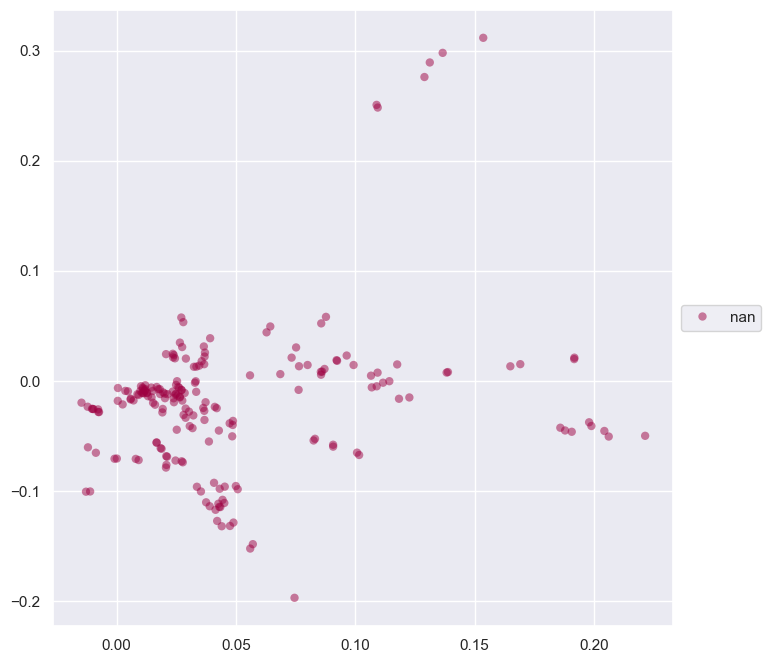

In [305]:
plot_pca(pca,bigwig_metadata=bigwig_metadata,metadata_label_column="Mapped read length")

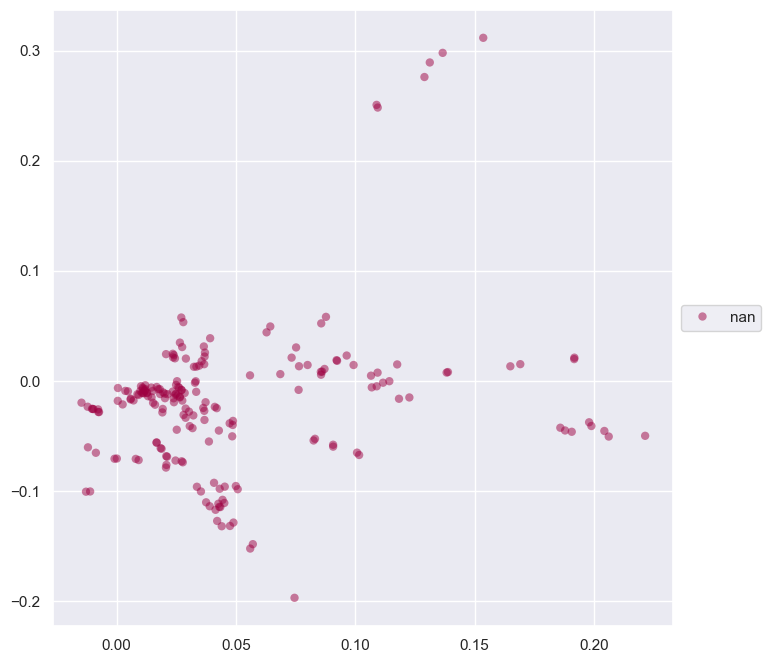

In [306]:
plot_pca(pca,bigwig_metadata=bigwig_metadata,metadata_label_column="Run type")

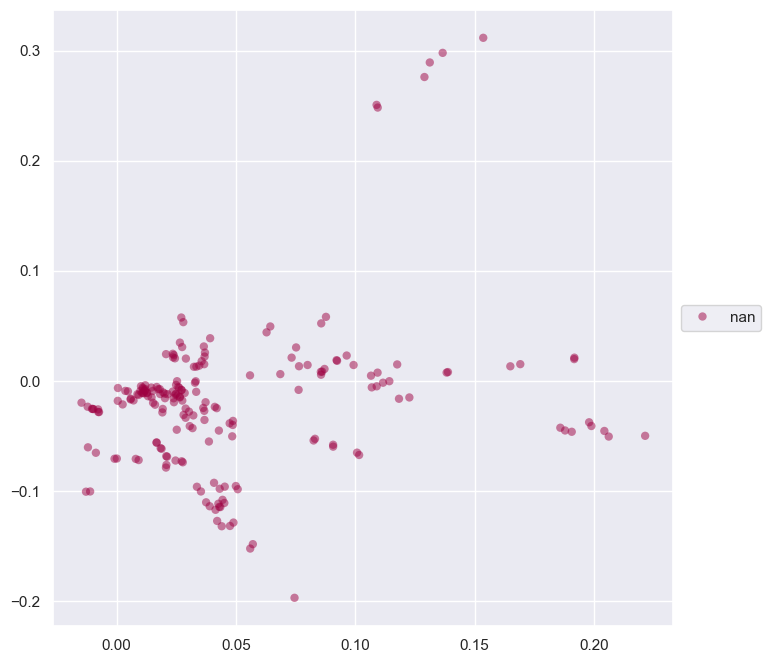

In [307]:
plot_pca(pca,bigwig_metadata=bigwig_metadata,metadata_label_column="Paired end")

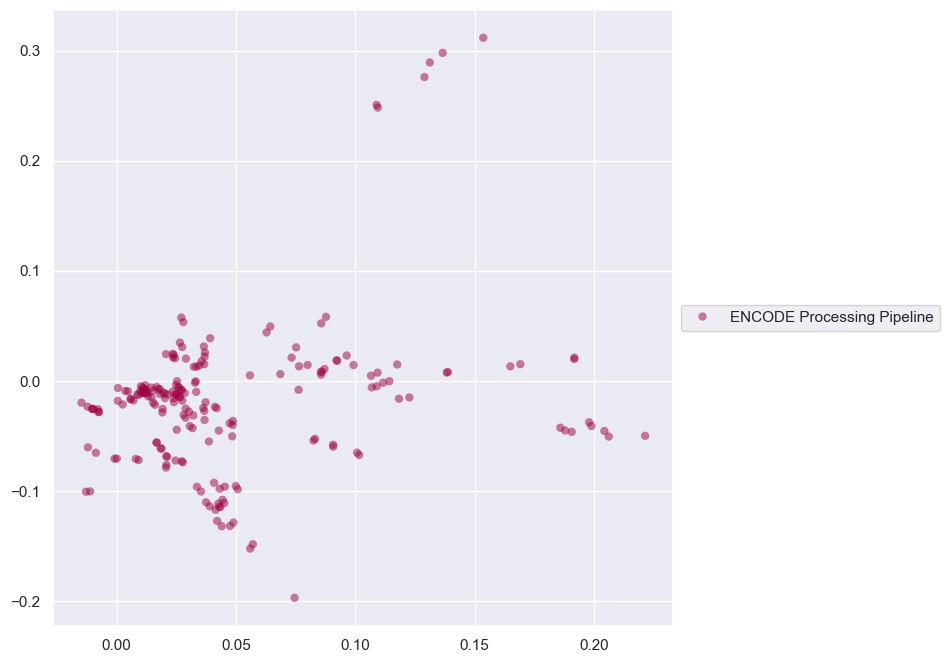

In [308]:
plot_pca(pca,bigwig_metadata=bigwig_metadata,metadata_label_column="Lab")

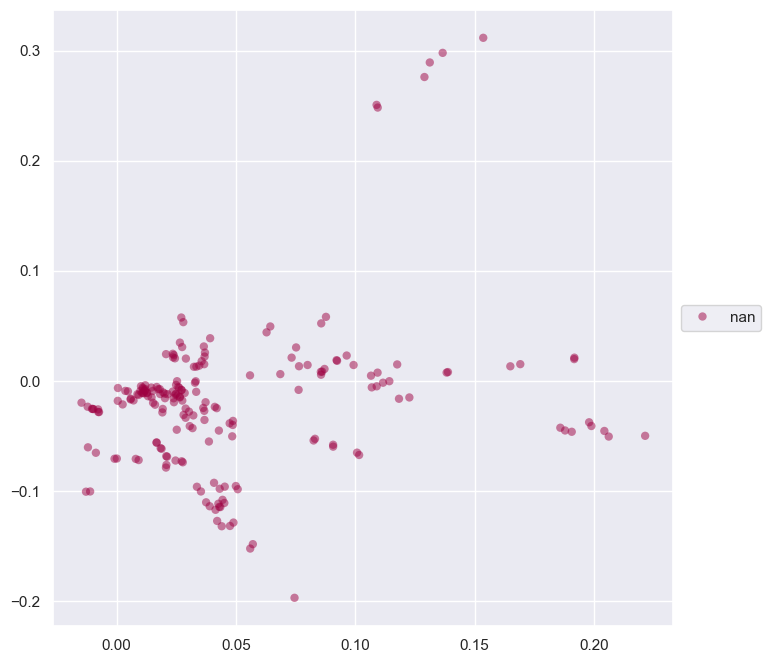

In [310]:
plot_pca(pca,bigwig_metadata=bigwig_metadata,metadata_label_column="Genome annotation")

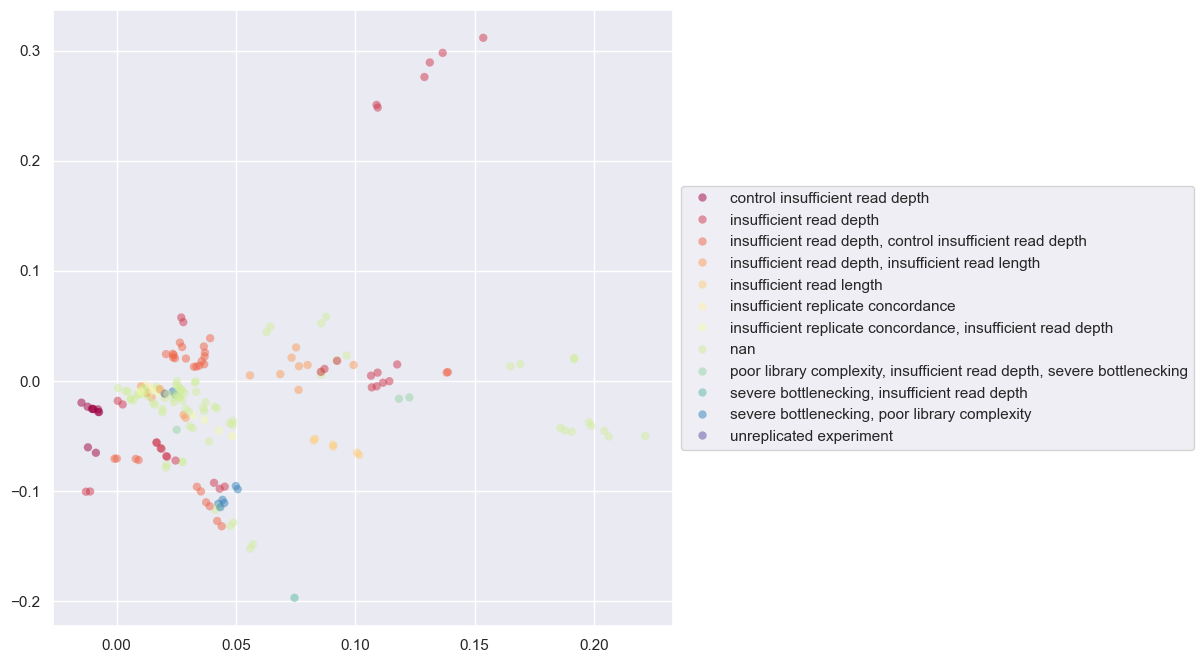

In [311]:
plot_pca(pca,bigwig_metadata=bigwig_metadata,metadata_label_column="Audit NOT_COMPLIANT")

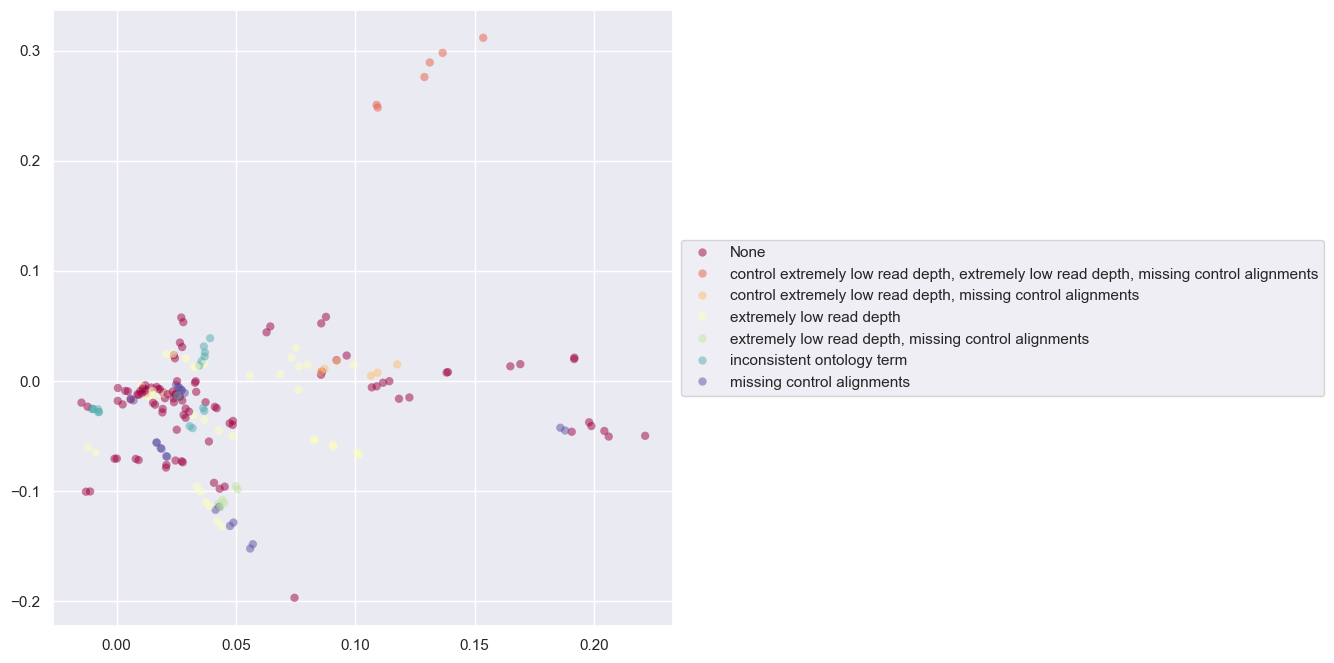

In [312]:
##Category 1 in Audit Error 
plot_pca(pca,bigwig_metadata=bigwig_metadata,metadata_label_column="Audit ERROR")

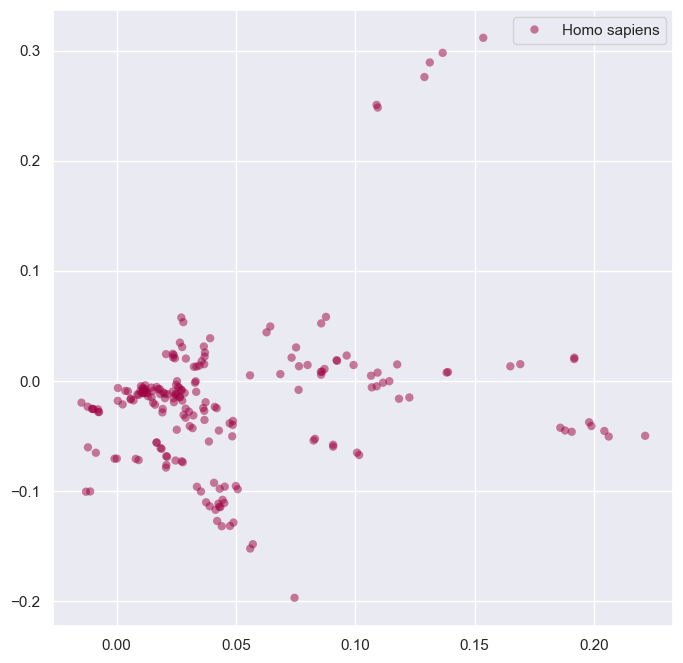

In [286]:
plot_pca(pca,bigwig_metadata=bigwig_metadata,metadata_label_column="Biosample organism")

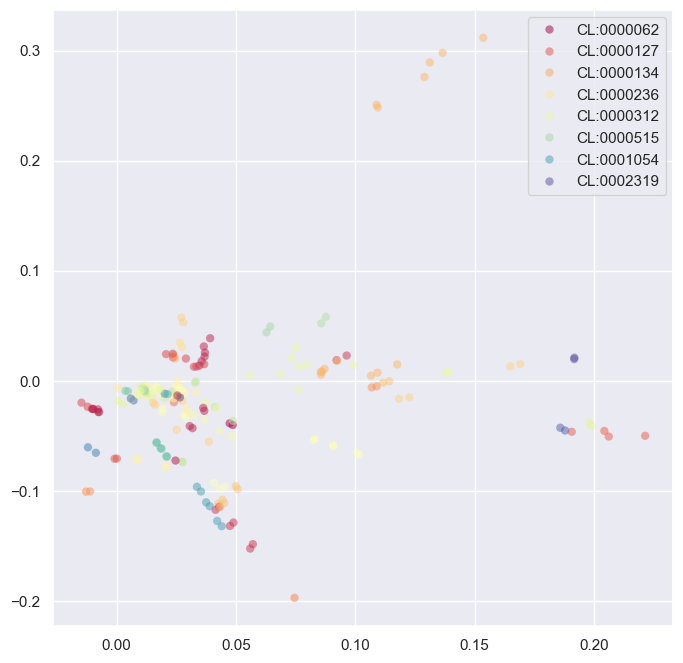

In [287]:
plot_pca(pca,bigwig_metadata=bigwig_metadata,metadata_label_column="Biosample term id")

Based on the column "Audit Error", we actually noticed that a subset of experiments that lie in the upper right corner seem to be the only experiments to have "control extremely low read depth, extremely low read depth, missing control alignments." We decided to remove those outliers from further analysis.

We also noticed that the 200 experiments in our data all have the same output type which is fold change over control. Hence, it is not necessary to do a separate analysis between "fold change over control" and "signal p-values". 

The PCA also shows a separation between TF ChIP-seq and Histone ChIP-seq. We are going to look at those assays separately in our downstream analysis.

In [ ]:
#Removing outliers based on the audit error column. Those points are the only experiment that have a PC2 component
#score higher than 0.2. 

#filter metadata and filter the df -- use those downstream (create filtered_df)


### 4. Which Assays or Experiment Targets show broad vs narrow patterns with respect to genomic position? Is this consistent across cell types? Does this relate to the patterns seen in PCA? One way to investigate the characteristic scale is by computing the autocorrelation.

In [53]:
#Let's filter the metadata to only contain the experiments that in the df.
filtered_bigwig_metadata=bigwig_metadata[bigwig_metadata["File accession"].isin(df.columns[3:])]

Let's start with looking at the variation within the experiments when it comes to assays (TF ChIP-seq or Histone ChIP-Seq).

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<function matplotlib.pyplot.show(close=None, block=None)>

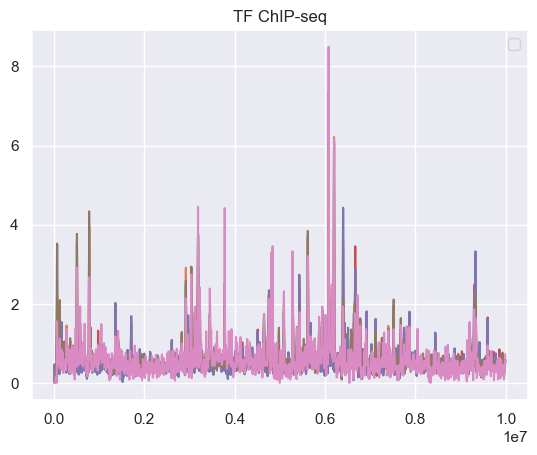

In [124]:
#This is using the assay: TF ChIP-seq
plt.plot(df.start[1:1000],df.ENCFF616VTY[1:1000])
plt.plot(df.start[1:1000],df.ENCFF911FWI[1:1000])
plt.plot(df.start[1:1000],df.ENCFF057LPE[1:1000])
plt.plot(df.start[1:1000],df.ENCFF312UWU[1:1000])
plt.plot(df.start[1:1000],df.ENCFF057LPE[1:1000])
plt.plot(df.start[1:1000],df.ENCFF953CVO[1:1000])
plt.plot(df.start[1:1000],df.ENCFF528ORD[1:1000])

plt.title("TF ChIP-seq")
plt.legend()
plt.show

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<function matplotlib.pyplot.show(close=None, block=None)>

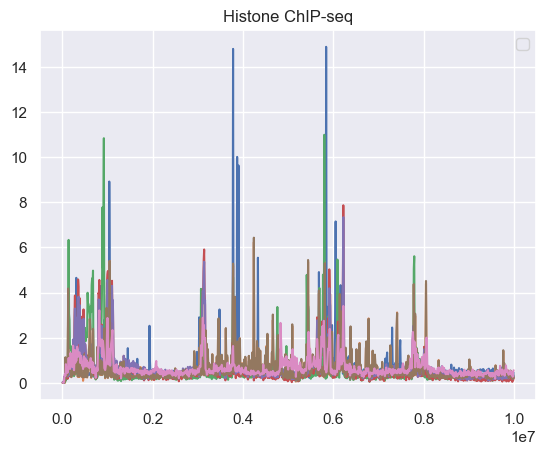

In [123]:
#This is using the assay: Histone ChIP-seq
plt.plot(df.start[1:1000],df.ENCFF781ZDY[1:1000])
plt.plot(df.start[1:1000],df.ENCFF520IHF[1:1000])
plt.plot(df.start[1:1000],df.ENCFF429ZOO[1:1000])
plt.plot(df.start[1:1000],df.ENCFF589QXD[1:1000])
plt.plot(df.start[1:1000],df.ENCFF037ACM[1:1000])
plt.plot(df.start[1:1000],df.ENCFF195GEW[1:1000])
plt.plot(df.start[1:1000],df.ENCFF920MFN[1:1000])

plt.title("Histone ChIP-seq")
plt.legend()
plt.show

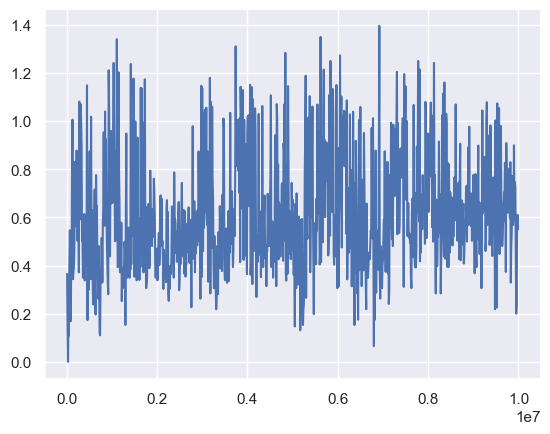

In [122]:
#ATAC-seq: ENCFF890LTR
plt.plot(df.start[1:1000],df.ENCFF890LTR[1:1000])

In [113]:
filtered_bigwig_metadata_new = filtered_bigwig_metadata[filtered_bigwig_metadata['Assay'] == 'Histone ChIP-seq']

It seems that the assay "TF ChIP-seq" displays a more narrow pattern across the experiments with less variation than what we see in the assay "Histone ChIP-seq". In the histone ChIP-seq assay, there seems to be more variations across the individual experiments. This means that the histone ChIP-seq data displays more broad patterns across individual experiments.

Is this consistent across cell types? Let's try out the ChIP-seq assay first and look at fibroblast of dermis, B cells and mesenchymal stem cells.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<function matplotlib.pyplot.show(close=None, block=None)>

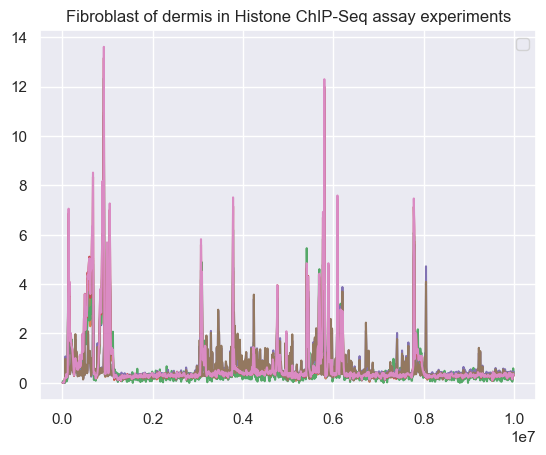

In [153]:
#This is using the assay: Histone ChIP-seq and looking at the fibroblast of dermis
plt.plot(df.start[1:1000],df.ENCFF429ZOO[1:1000])
plt.plot(df.start[1:1000],df.ENCFF171XAI[1:1000]) 
plt.plot(df.start[1:1000],df.ENCFF315VTD[1:1000]) 
plt.plot(df.start[1:1000],df.ENCFF136EQS[1:1000]) 
plt.plot(df.start[1:1000],df.ENCFF061IKO[1:1000])
plt.plot(df.start[1:1000],df.ENCFF471BTF[1:1000])
plt.plot(df.start[1:1000],df.ENCFF861SNZ[1:1000])

plt.title("Fibroblast of dermis in Histone ChIP-Seq assay experiments")
plt.legend()
plt.show

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<function matplotlib.pyplot.show(close=None, block=None)>

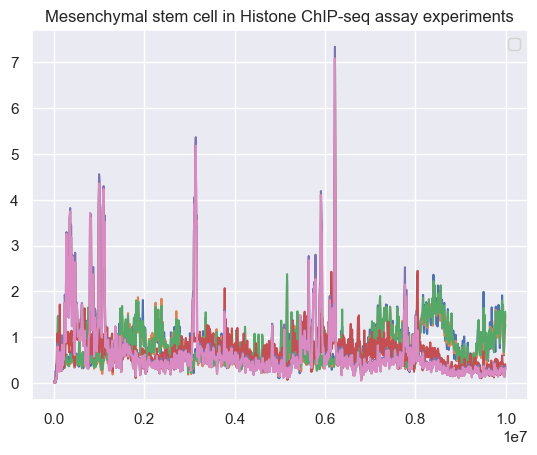

In [154]:
#This is using the assay: Histone ChIP-seq and looking at the mesenchymal stem cell type
plt.plot(df.start[1:1000],df.ENCFF609VYV[1:1000])
plt.plot(df.start[1:1000],df.ENCFF636NVM[1:1000]) 
plt.plot(df.start[1:1000],df.ENCFF521PSG[1:1000]) 
plt.plot(df.start[1:1000],df.ENCFF730DGP[1:1000]) 
plt.plot(df.start[1:1000],df.ENCFF037ACM[1:1000]) 
plt.plot(df.start[1:1000],df.ENCFF278HYJ[1:1000]) 
plt.plot(df.start[1:1000],df.ENCFF278HYJ[1:1000]) 


plt.title("Mesenchymal stem cell in Histone ChIP-seq assay experiments")
plt.legend()
plt.show

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<function matplotlib.pyplot.show(close=None, block=None)>

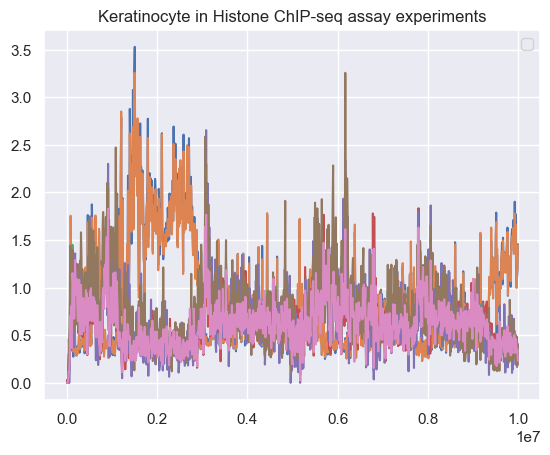

In [162]:
#This is using the assay: Histone ChIP-seq and looking at the keratinocyte cell type
plt.plot(df.start[1:1000],df.ENCFF251CYW[1:1000])
plt.plot(df.start[1:1000],df.ENCFF568EAV[1:1000])
plt.plot(df.start[1:1000],df.ENCFF534PKF[1:1000])
plt.plot(df.start[1:1000],df.ENCFF261ANP[1:1000])
plt.plot(df.start[1:1000],df.ENCFF528HSW[1:1000])
plt.plot(df.start[1:1000],df.ENCFF260LXG[1:1000])
plt.plot(df.start[1:1000],df.ENCFF075EYX[1:1000])

plt.title("Keratinocyte in Histone ChIP-seq assay experiments")
plt.legend()
plt.show

Is this consistent across cell types within the TF ChIP-seq assay? Let's try with fibroblast of lung and K562 and GM12878

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<function matplotlib.pyplot.show(close=None, block=None)>

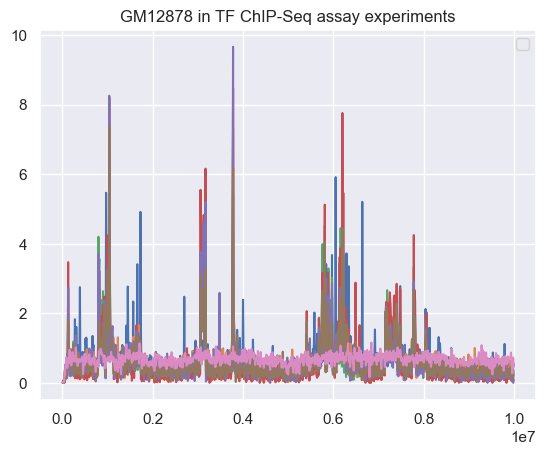

In [166]:
#This is using the assay: TF ChIP-seq and looking at GM12878
plt.plot(df.start[1:1000],df.ENCFF107LDM[1:1000])
plt.plot(df.start[1:1000],df.ENCFF969AEB[1:1000]) 
plt.plot(df.start[1:1000],df.ENCFF073PAC[1:1000]) 
plt.plot(df.start[1:1000],df.ENCFF951UCA[1:1000]) 
plt.plot(df.start[1:1000],df.ENCFF620RSQ[1:1000])
plt.plot(df.start[1:1000],df.ENCFF635HGL[1:1000])
plt.plot(df.start[1:1000],df.ENCFF243XPP[1:1000])

plt.title("GM12878 in TF ChIP-Seq assay experiments")
plt.legend()
plt.show

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<function matplotlib.pyplot.show(close=None, block=None)>

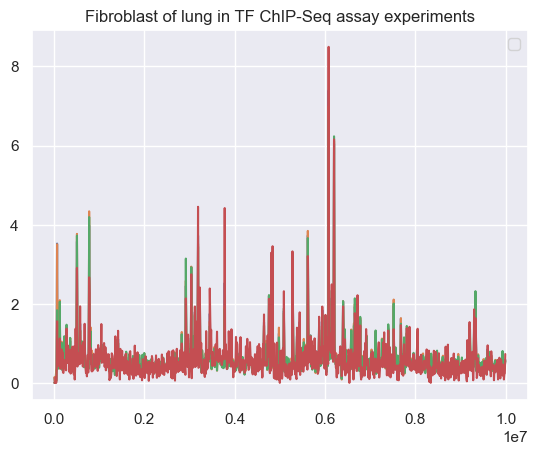

In [169]:
#This is using the assay: TF ChIP-seq and looking at fibroblast of lung
plt.plot(df.start[1:1000],df.ENCFF616VTY[1:1000])
plt.plot(df.start[1:1000],df.ENCFF953CVO[1:1000]) 
plt.plot(df.start[1:1000],df.ENCFF567WCU[1:1000]) 
plt.plot(df.start[1:1000],df.ENCFF528ORD[1:1000]) 

plt.title("Fibroblast of lung in TF ChIP-Seq assay experiments")
plt.legend()
plt.show

It seems that within different cell types, the TF ChIP-seq has a narrower pattern of expression and less variant across experiments. However, the histone ChIP-seq has a broader pattern of expression and we encounter more variants across experiments within the cell types. 

In the PCA, the Histone ChIP-seq data seems to be more spreadout across the landscape than the TF ChIP-seq data that is concentrated in one area in the PCA plot (in the bottom left corner and less spread out). This confirms what we plotted above that that shows that the histone ChIP-seq data has a broader pattern than the TF ChIP-seq data.

## WHAT IS AUTOCORRELATION??

### 5.Which "Experiment Targets" (e.g. histone marks or transcription factors) for which cell types are nearby in this PC1 vs PC2 space? Do any of these proximities have plausible biological interpretations? For example, are any polycomb-related factors in proximity? Illustrate this in a plot.

In [214]:
#Adding a new column that combines experiment targets and cell type in the filtered_bigwig_metadata
filtered_bigwig_metadata["cell_type_target"] = filtered_bigwig_metadata["Biosample term name"].astype(str) +"-"+ filtered_bigwig_metadata["Experiment target"]


/var/folders/vh/c9rgmxsx7rx9w6jhh5l01ymc0000gn/T/ipykernel_4388/2270933787.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_bigwig_metadata["cell_type_target"] = filtered_bigwig_metadata["Biosample term name"].astype(str) +"-"+ filtered_bigwig_metadata["Experiment target"]


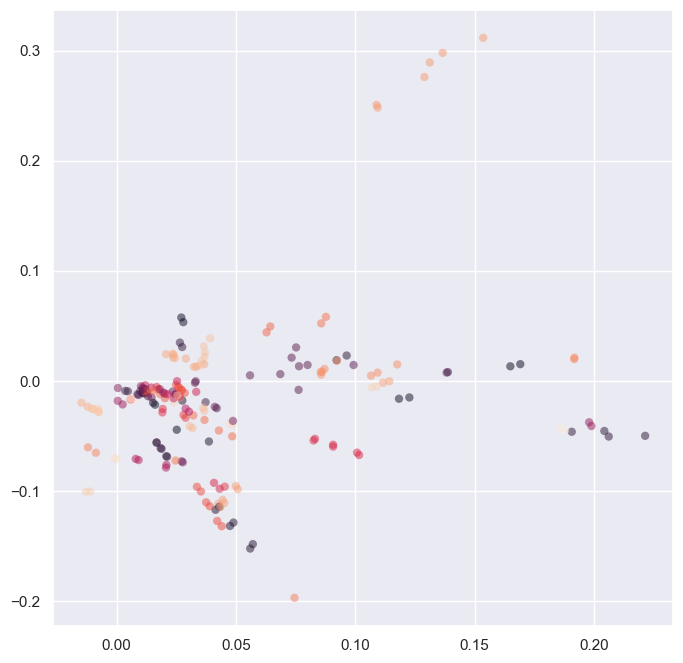

In [219]:
plot_pca(pca,bigwig_metadata=filtered_bigwig_metadata,metadata_label_column="cell_type_target")

In [ ]:
plt.scatter(df2_pca[:, 0], df2_pca[:, 1],
            c=bigwig_metadata_filet.start, edgecolor='none', alpha=0.5)
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

### 6. How much does preprocessing matter? Try normalizing the variance per track and see if you arrive at similar or distinct conclusions. Try removing the region on chr10 mentioned above. Note that sklearn.preprocessing.StandardScaler could be useful for preprocessing.

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(df2)
scaled_df2 = scaler.transform(df2)
scaled_df2_project = scaler.fit_transform(df2)

In [ ]:
plt.scatter(scaled_df2_project[:, 0], scaled_df2_project[:, 1],
            c=scaled_df2_project.start, edgecolor='none', alpha=0.5)
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

In [ ]:
from pandas import DataFrame
normalized_df = DataFrame(scaled_df2_project)
normalized_df.columns = x.columns
normalized_df["start"] = df.start
normalized_df["end"] = df.end 

### 7. How many PCs are needed to explain 90% of the variance in the data? Illustrate this with a scree plot (https://en.wikipedia.org/wiki/Scree_plot).


### 8. How different is the dimensionality reduction into two dimensions for PCA from that obtained using MDS (multi-dimensional scaling)? What methods could be used to determine the similarity? Illustrate with a plot.

In [222]:
from sklearn.datasets import load_digits
from sklearn.manifold import MDS
embedding = MDS(n_components=2)
df2_transformed = embedding.fit_transform(df2)
#df_transformed.shape

KeyboardInterrupt: 

### 9. Would non-negative matrix factorization (https://en.wikipedia.org/wiki/Non-negative_matrix_factorization) be a useful method to use for this dataset? Why or why not? (No plots needed for this question).

We think NMF would be useful for this data set. Using PCA on our data doesn't give us good clustering. This may be due to the complexity of our data. Furthermore, PCA is best for linearly separable data.

NMF is also useful in finding the experiments most representative of the clusters. This is because NMF leads to zeros for factors that don’t contribute.

In [ ]:
filtered_bigwig_metadata_new = filtered_bigwig_metadata[filtered_bigwig_metadata['Assay'] == 'TF ChIP-seq']
#filtered_bigwig_metadata_new['Biosample term name'].tolist()
filtered_bigwig_metadata_new_just_lung = filtered_bigwig_metadata_new[filtered_bigwig_metadata_new['Biosample term name'] == 'fibroblast of lung']
filtered_bigwig_metadata_new_just_lung